# Dependencias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import folium as folium
from folium import IFrame
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib_venn import venn3, venn3_circles
sns.set(rc={'figure.figsize':(12,8)})
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

_________________
# Análisis general y Filtrado de datos

In [3]:
df_original = pd.read_csv("train.csv", dtype={
    'tipodepropiedad':'category', 'ciudad':'category',\
    'provincia':'category', 'gimnasio':'bool', 'usosmultiples':'bool',\
    'piscina':'bool', 'escuelascercanas':'bool',\
    'centroscomercialescercanos':'bool' }, parse_dates=[16])

In [4]:
# Renombramos convenientemente algunas columnas
df_original = df_original.rename(columns={'tipodepropiedad':'tipo', 'habitaciones':'cant_habitaciones', 'garages':'cant_garages', 'banos':'cant_banios',
       'lat':'latitud', 'lng':'longitud'})

In [5]:
df_original['anio'] = df_original['fecha'].dt.year

In [6]:
df_original['mes'] = df_original['fecha'].dt.month

In [7]:
df_original.columns

Index(['id', 'titulo', 'descripcion', 'tipo', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'cant_habitaciones', 'cant_garages',
       'cant_banios', 'metroscubiertos', 'metrostotales', 'idzona', 'latitud',
       'longitud', 'fecha', 'gimnasio', 'usosmultiples', 'piscina',
       'escuelascercanas', 'centroscomercialescercanos', 'precio', 'anio',
       'mes'],
      dtype='object')

In [8]:
df_filtrado = df_original.copy()

## Identificamos para cada columna qué porcentaje de los datos de cada columna son nulos 

Separamos entre los que son mayores al 1% y menores ya que no serían notables en la misma escala, haciendo más fácil de identificar los que tienen 0%.

In [9]:
porcentajes = df_original.isna().sum()/len(df_original.index)*100

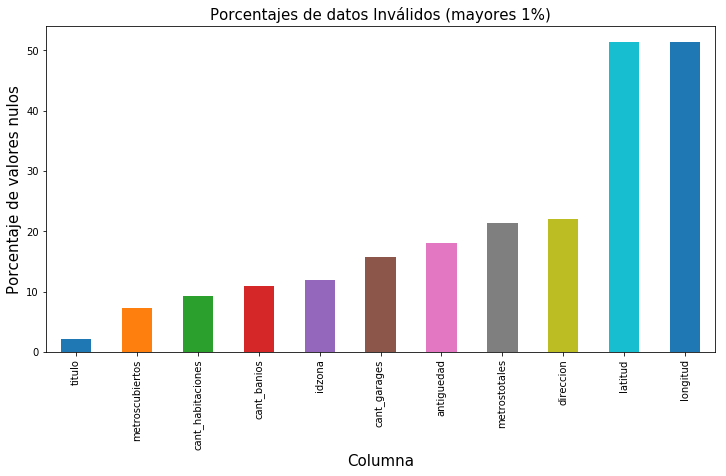

In [10]:
porcentajes_mayores_1 = porcentajes[porcentajes >= 1]
g = porcentajes_mayores_1.sort_values().plot(kind='bar',figsize=(12, 6), color=sns.color_palette())
g.set_xlabel("Columna", fontsize=15)
g.set_ylabel("Porcentaje de valores nulos", fontsize=15)
g.set_title("Porcentajes de datos Inválidos (mayores 1%)", fontsize=15)
sns.set(palette='muted')

Text(0.5, 1.0, 'Porcentajes de datos Inválidos (menores 1%)')

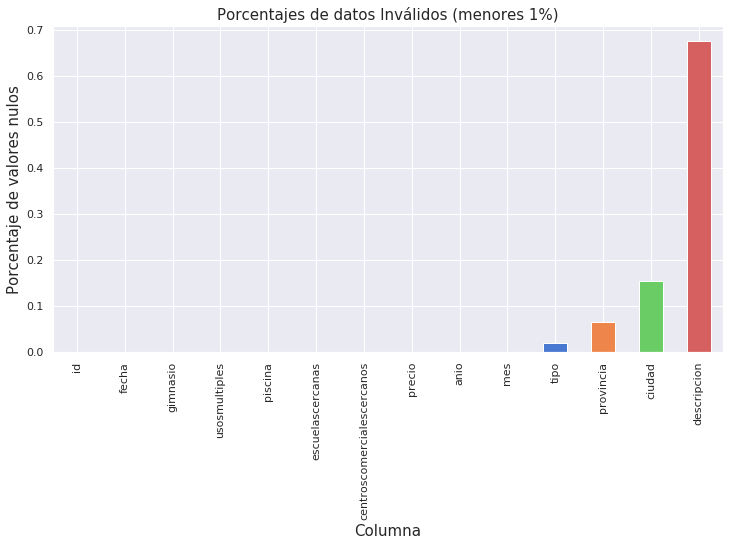

In [11]:
porcentajes_menores_1 = porcentajes[porcentajes < 1]
g = porcentajes_menores_1.sort_values().plot(kind='bar',figsize=(12, 6), color=sns.color_palette())
g.set_xlabel("Columna", fontsize=15)
g.set_ylabel("Porcentaje de valores nulos", fontsize=15)
g.set_title("Porcentajes de datos Inválidos (menores 1%)", fontsize=15)

______________________________________
# Análisis de las descripciones

In [12]:
#Filtro aquellas publicaciones que no tengan descripciones
df_filtrado_descripciones = df_filtrado.loc[~df_filtrado.descripcion.isnull()]

In [13]:
def filtrar_descripciones(descripcion):
    descripcion = descripcion.replace("\n", "")
    descripcion = descripcion.replace("<p>", "")
    descripcion = descripcion.replace("<\p>", "")
    descripcion = descripcion.replace("nbsp", "")
    descripcion = descripcion.replace("ntilde", "")
    descripcion = descripcion.replace("ntil", "")
    descripcion = descripcion.replace("strong","")
    palabras = descripcion.split()
    for palabra in palabras:
        if len(palabra) <= 3:
            palabras.remove(palabra)
    descripcion_final = " ".join(palabras)
    return descripcion_final

df_filtrado_descripciones['descripcion'] = df_filtrado_descripciones['descripcion'].apply(filtrar_descripciones)

In [14]:
descripciones = " ".join(descripcion for descripcion in df_filtrado_descripciones.descripcion)
print ("Hay {} palabras en total que conforman todas las descripciones".format(len(descripciones)))

Hay 83595332 palabras en total que conforman todas las descripciones


In [15]:
#Ajusto el WordCloud a la forma de una casa
mascara_casa = np.array(Image.open("files/casa.png"))
mascara_casa

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [16]:
def transformar_formato(valor):
    if valor == 0:
        return 255
    else:
        return valor

mascara_casa_transformada = np.ndarray((mascara_casa.shape[0],mascara_casa.shape[1]), np.int32)
for i in range(len(mascara_casa)):
    mascara_casa_transformada[i] = list(map(transformar_formato, mascara_casa[i]))
    
mascara_casa_transformada

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=int32)

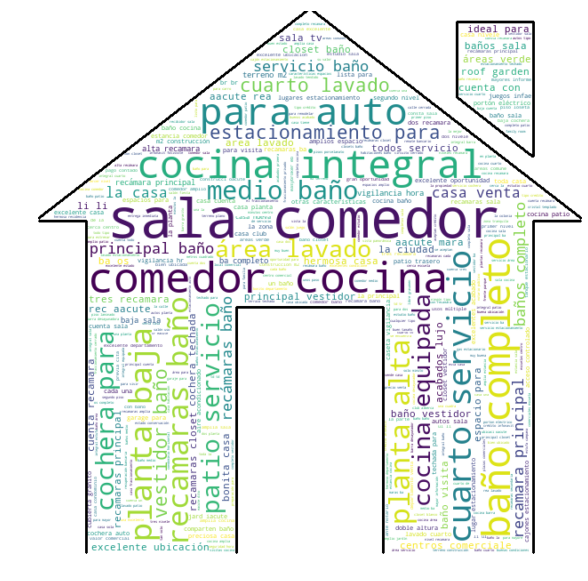

In [17]:
# Creo la imagen del WordCloud
wc = WordCloud(background_color="white", max_words=1000, mask=mascara_casa_transformada, contour_width=3, contour_color='black')

# Genero a partir de las palabras de las descripciones
wc.generate(descripciones)

# Lo guardo en un archivo
wc.to_file("files/wordcloud_casa.png")

# Mostrar
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

______________________________________
# Análisis por tipo de propiedad

In [18]:
# Los que no tienen tipo definido (en el gráfico anterior se muestra que son muy pocos)
df_original.dropna(axis=0, subset=['tipo'], inplace=True)

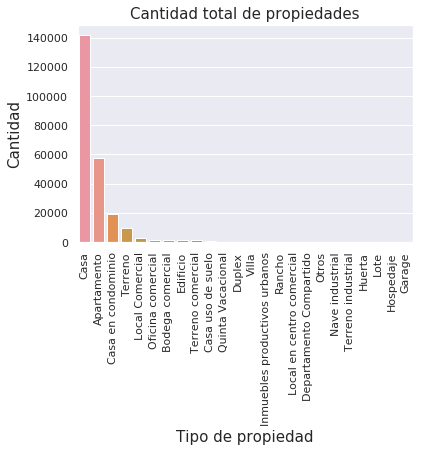

In [19]:
g = sns.countplot(x='tipo', data=df_original, order=df_original['tipo'].value_counts().index, orient='v')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_xlabel("Tipo de propiedad", fontsize=15)
g.set_ylabel("Cantidad", fontsize=15)
g.set_title("Cantidad total de propiedades", fontsize=15)
sns.set(rc={'figure.figsize':(10,8)})


In [20]:
asdf = dict(df_original['tipo'].value_counts() > 300)

df_original = df_original[[asdf[x] for x in df_original['tipo']]]
df_original['tipo'] = df_original['tipo'].astype('object').astype('category')

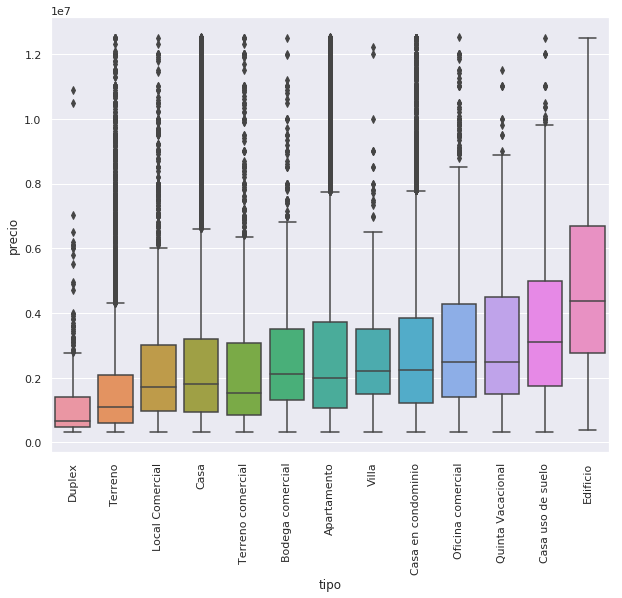

In [21]:
g = sns.boxplot(x=df_original['tipo'], y=df_original['precio'], order=df_original.groupby('tipo')['precio'].mean().sort_values().index)
_ = g.set_xticklabels(g.get_xticklabels(),rotation=90)
sns.set(rc={'figure.figsize':(12,8)})


En base a los dos gráficos anteriores decidimos que todos los que tuvieran menos datos que 'Casa en Condominio' serían agrupados en 3 grupos según su precio. Así armaremos los siguientes conjuntos.

In [22]:
individuales = set(['Casa', 'Apartamento', 'Casa en condominio', 'Edificio'])
comerciales = set(['Local Comercial', 'Bodega comercial', 'Oficina comercial'])
terrenos = set(['Terreno comercial', 'Terreno'])


In [23]:
# funcion para setear los tipos
def set_tipo(tipo):
    if tipo in individuales:
        return tipo
    elif tipo in comerciales:
        return 'Comercial'
    elif tipo in terrenos:
        return 'Terreno'
    return 'Otros Inmuebles'


In [24]:
df_filtrado['tipo'] = df_filtrado['tipo'].apply(set_tipo)
df_filtrado['tipo'].value_counts(normalize = 1)*100

Casa                                59.06
Apartamento                         23.90
Casa en condominio                   8.04
Terreno                              4.70
Comercial                            2.58
Otros Inmuebles                      1.14
Edificio                             0.58
Name: tipo, dtype: float64

De esta forma, agrupamos en menos categorías de las cuales tenemos más información.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e4d91aef0>],
      dtype=object)

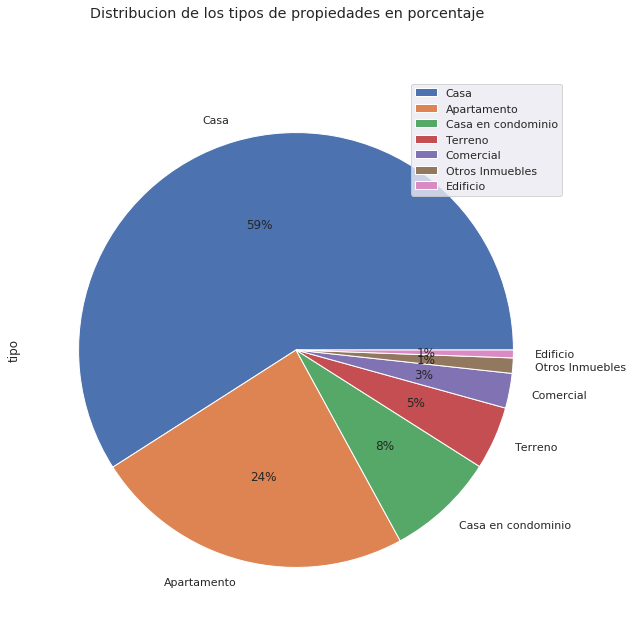

In [25]:
# un grafico de presentar percentajes de cada tipo
df_tipo = df_filtrado['tipo'].value_counts().to_frame()
df_tipo.plot(kind='pie', subplots=True, figsize=(10, 10), autopct='%1.0f%%',title='Distribucion de los tipos de propiedades en porcentaje')

______________________________________
# Análisis metrostotales y metroscubiertos

A los datos del dataframe que tienen una de las columnas (de 'metrostotales' y 'metroscubiertos') pero no la otra, copiamos el dato de una a la otra según sea necesario.

In [26]:
## funcion para setear los superficies
def set_metros(row):
    total = row.metrostotales
    covered = row.metroscubiertos
    if np.isnan(total):
        row.metrostotales = covered
        return row
    if np.isnan(covered):
        row.metroscubiertos = total
        return row
    return row

In [27]:
df_filtrado[['metrostotales', 'metroscubiertos']] = df_filtrado[['metrostotales', 'metroscubiertos']].apply(set_metros, axis = 1)

## Agregamos columna de precio por metro 

In [28]:
df_filtrado['precio por metros'] = df_filtrado.precio/df_filtrado.metrostotales


______________________________________

# Analizando precio por tipo de propiedad

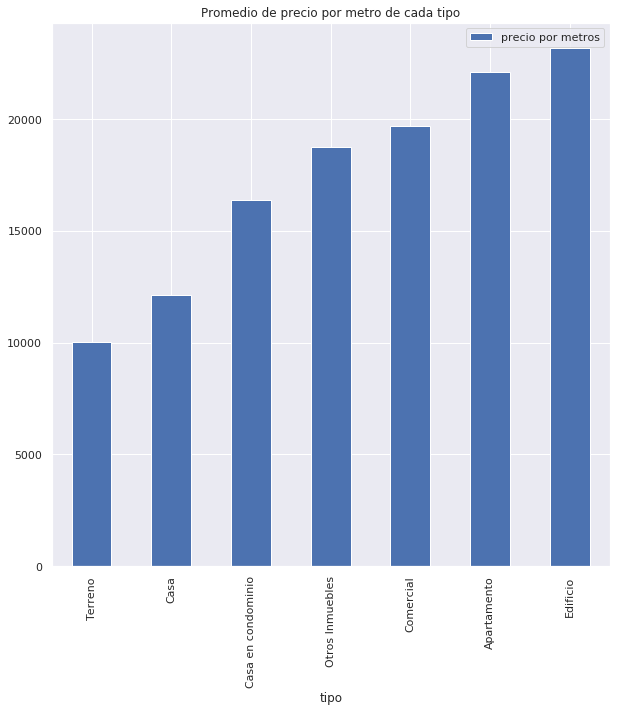

In [29]:
#analiza promedio de precio por medio de cada tipo
df_tipo_precio = df_filtrado[['tipo','precio por metros']]

df_tipo_precio.groupby('tipo').agg({'precio por metros':'mean'}).sort_values('precio por metros').plot(kind='bar', figsize = (10,10),title = 'Promedio de precio por metro de cada tipo')

Analizando promedio de precio por metro en cada provincia segun el tipo

In [30]:
#filtrando uno con precio tipo y provincia (falta elegir un mejor grafico)
df_tipo_provincia = df_filtrado[['provincia','precio por metros','tipo']]
df_tp = df_tipo_provincia.groupby(['tipo','provincia']).agg({'precio por metros' :'mean'})
df_tp = df_tp.reset_index()

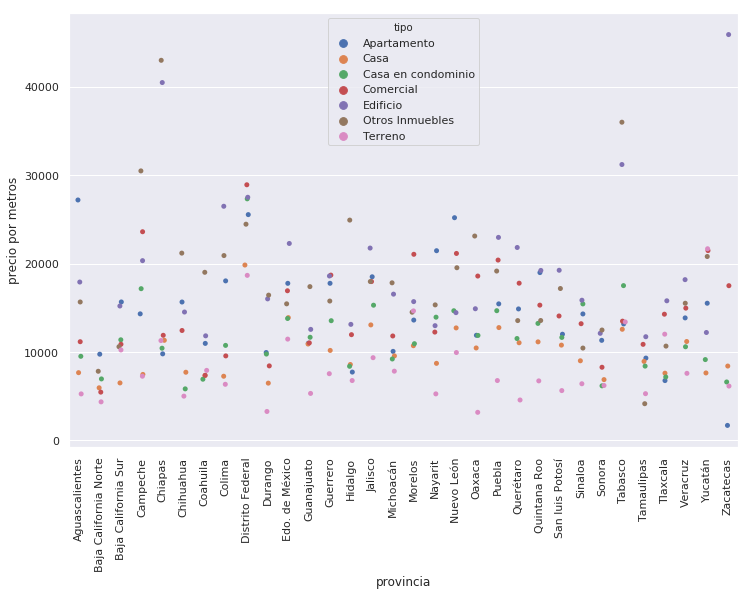

In [31]:
g= sns.stripplot(x='provincia', y='precio por metros', hue= 'tipo', data=df_tp, order=None, 
                      hue_order=None, jitter=True, 
                      dodge=False, orient=None, 
                      color=None, palette=None, size=5, 
                      edgecolor="gray", linewidth=0, 
                      ax=None)
_ = g.set_xticklabels(g.get_xticklabels(),rotation=90)


______________________________________
# Analizando los factores de escuelas y centroscomerciales sobre el precio

,precio por metros
escuelascercanas,
False,"14,998.22"
True,"15,200.69"


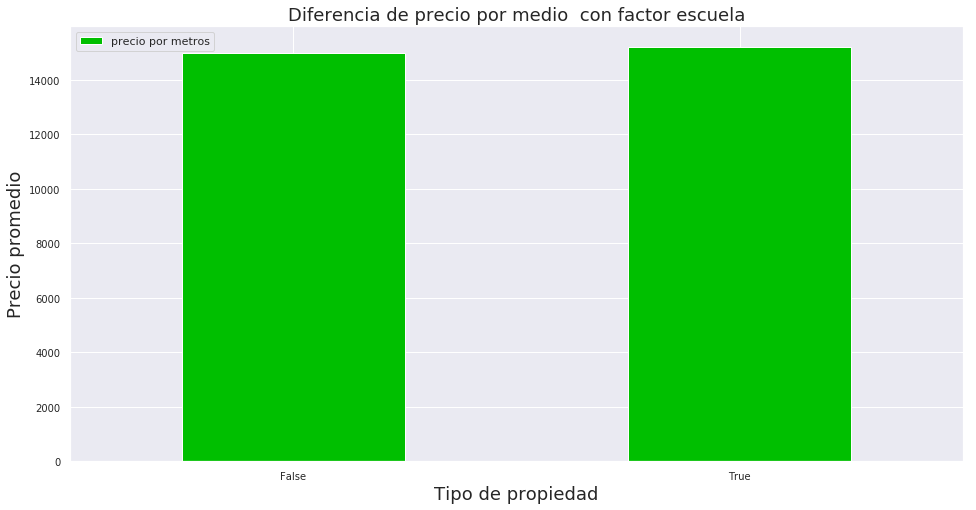

In [32]:
df_escuela = df_filtrado [['tipo','precio por metros', 'escuelascercanas']]
df_ec_precio = df_escuela.groupby('escuelascercanas').agg({'precio por metros' :'mean'})
g = df_ec_precio.plot(kind='bar', figsize=(16,8),color=(0, 0.75, 0.0),fontsize = 10)
g.set_title("Diferencia de precio por medio  con factor escuela", fontsize=18)
g.set_xlabel("Tipo de propiedad", fontsize=18)
g.set_ylabel("Precio promedio", fontsize=18)
g.set_xticklabels(g.get_xticklabels(),rotation=0)
df_ec_precio


In [33]:
# filtrar el factor escuelas con diferentes tipos
df_escuela = df_filtrado[['tipo','precio por metros', 'escuelascercanas']].groupby(['tipo','escuelascercanas']).agg({'precio por metros' :'mean'})
df_escuela = df_escuela.pivot_table(index="tipo", \
                                 columns="escuelascercanas", \
                                 values="precio por metros", fill_value=0)
df_escuela = df_escuela.reset_index()
df_escuela.set_index('tipo', inplace=True) 
df_escuela

escuelascercanas,False,True
tipo,,
Apartamento,"22,271.54","21,921.81"
Casa,"11,970.51","12,314.61"
Casa en condominio,"16,388.73","16,338.34"
Comercial,"19,095.22","21,816.92"
Edificio,"23,047.13","23,396.08"
Otros Inmuebles,"18,396.78","19,835.80"
Terreno,"9,694.75","10,653.30"


Text(0, 0.5, 'Precio promedio')

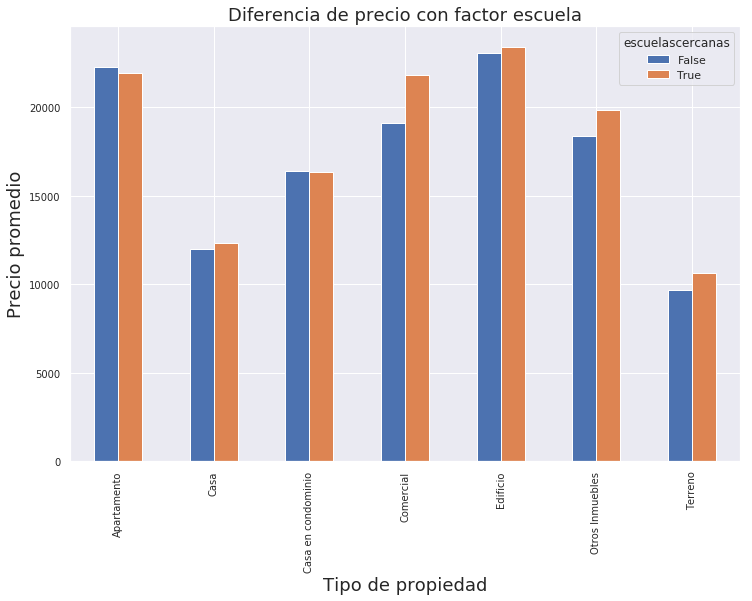

In [34]:
# representa en grafico
g = df_escuela.plot(kind='bar', fontsize = 10)
g.set_title("Diferencia de precio con factor escuela", fontsize=18)
g.set_xlabel("Tipo de propiedad", fontsize=18)
g.set_ylabel("Precio promedio", fontsize=18)

,precio por metros
centroscomercialescercanos,
False,"14,576.73"
True,"15,866.45"


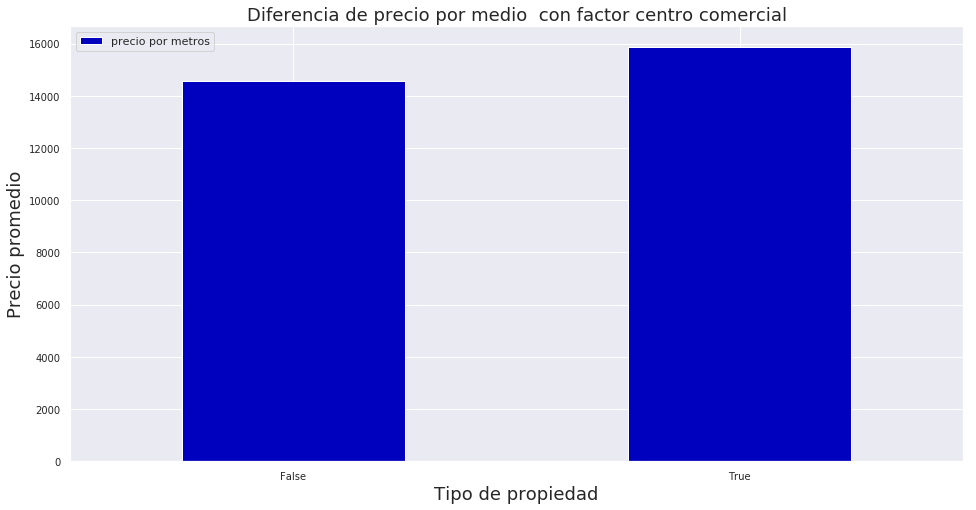

In [35]:
df_centrocomercial = df_filtrado [['tipo','precio por metros', 'centroscomercialescercanos']]
df_cc_precio = df_centrocomercial.groupby('centroscomercialescercanos').agg({'precio por metros' :'mean'})
g = df_cc_precio.plot(kind='bar',figsize=(16,8), color=(0, 0, 0.75),fontsize = 10)
g.set_title("Diferencia de precio por medio  con factor centro comercial", fontsize=18)
g.set_xlabel("Tipo de propiedad", fontsize=18)
g.set_ylabel("Precio promedio", fontsize=18)
g.set_xticklabels(g.get_xticklabels(),rotation=0)
df_cc_precio

In [36]:
#comparando el factor de centro con el promedio de precio
df_centrocomercial = df_filtrado[['tipo','precio por metros', 'centroscomercialescercanos']].groupby(['tipo', 'centroscomercialescercanos']).agg({'precio por metros' :'mean'})
df_centrocomercial = df_centrocomercial.pivot_table(index="tipo", \
                                 columns="centroscomercialescercanos", \
                                 values="precio por metros", fill_value=0)
df_centrocomercial = df_centrocomercial.reset_index()
df_centrocomercial.set_index('tipo', inplace=True) 
df_centrocomercial

centroscomercialescercanos,False,True
tipo,,
Apartamento,"21,832.81","22,449.95"
Casa,"11,770.65","12,695.52"
Casa en condominio,"16,416.36","16,301.57"
Comercial,"18,751.59","22,661.91"
Edificio,"22,841.66","23,836.71"
Otros Inmuebles,"18,345.21","20,034.41"
Terreno,"9,735.32","10,681.24"


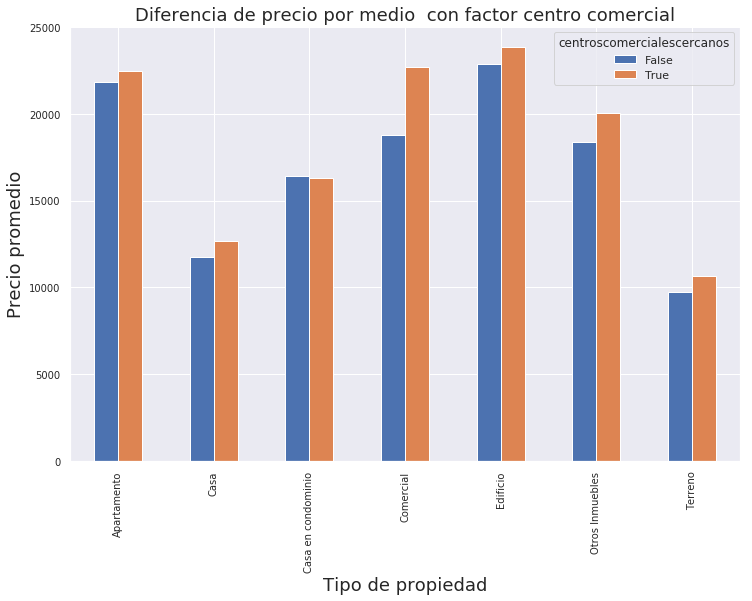

In [37]:
g = df_centrocomercial.plot(kind='bar', fontsize = 10)
g.set_title("Diferencia de precio por medio  con factor centro comercial", fontsize=18)
g.set_xlabel("Tipo de propiedad", fontsize=18)
g.set_ylabel("Precio promedio", fontsize=18)
_ = g.set_xticklabels(g.get_xticklabels(),rotation=90)
sns.set(rc={'figure.figsize':(12,8)})


______________________________________
# **Analisis segun antiguedad**

In [38]:
df_filtrado['tipo'].value_counts()

Casa                  141717
Apartamento            57341
Casa en condominio     19297
Terreno                11271
Comercial               6202
Otros Inmuebles         2730
Edificio                1396
Name: tipo, dtype: int64

In [39]:
#Me quedo con aquellas publicaciones que tengan valores consistentes.

df_filtrado_antiguedad = df_filtrado.loc[df_filtrado['metrostotales'] > 0]
df_filtrado_antiguedad = df_filtrado_antiguedad.loc[df_filtrado_antiguedad['metroscubiertos'] > 0]

#Me quedo con tipos: Casa, Apartamento y Casa en condominio

df_filtrado_antiguedad = df_filtrado_antiguedad.loc[[x in individuales for x in df_filtrado['tipo']]]

In [40]:
#Filtro las publicaciones que no tienen antiguedad ni precio

df_filtrado_antiguedad = df_filtrado_antiguedad.loc[df_filtrado_antiguedad['antiguedad']>=0]
df_filtrado_antiguedad = df_filtrado_antiguedad.loc[df_filtrado_antiguedad['precio']>0]

#Calculo precio por m2

df_filtrado_antiguedad['precio por metros'] = df_filtrado_antiguedad['precio'] / df_filtrado_antiguedad['metrostotales']

In [41]:
#Calculo el promedio de precio por metros segun la antiguedad por tipo (Casa, Apartamento, Casa en condominio)

df_filtered_casa = df_filtrado_antiguedad.loc[df_filtrado_antiguedad['tipo'] == 'Casa']
preciom2_segun_antiguedad_casa = df_filtered_casa.groupby('antiguedad').agg({'precio por metros' : 'mean', 'id' : 'count'})
preciom2_segun_antiguedad_casa.reset_index(inplace = True)
preciom2_segun_antiguedad_casa.columns = ['antiguedad', 'precio por metros', 'cantidaddepublicaciones']

df_filtered_apartamento = df_filtrado_antiguedad.loc[df_filtrado_antiguedad['tipo'] == 'Apartamento']
preciom2_segun_antiguedad_apartamento = df_filtered_apartamento.groupby('antiguedad').agg({'precio por metros' : 'mean', 'id' : 'count'})
preciom2_segun_antiguedad_apartamento.reset_index(inplace = True)
preciom2_segun_antiguedad_apartamento.columns = ['antiguedad', 'precio por metros', 'cantidaddepublicaciones']

df_filtered_casa_condo = df_filtrado_antiguedad.loc[df_filtrado_antiguedad['tipo'] == 'Casa en condominio']
preciom2_segun_antiguedad_casa_condo = df_filtered_casa_condo.groupby('antiguedad').agg({'precio por metros' : 'mean', 'id' : 'count'})
preciom2_segun_antiguedad_casa_condo.reset_index(inplace = True)
preciom2_segun_antiguedad_casa_condo.columns = ['antiguedad', 'precio por metros', 'cantidaddepublicaciones']

In [42]:
#Filtro aquellos anios de antiguedad que tengan muy pocas publciaciones, asi se toman valores muestrales representativos.

cantidad_promedio_casa = preciom2_segun_antiguedad_casa['cantidaddepublicaciones'].mean()
preciom2_segun_antiguedad_casa = preciom2_segun_antiguedad_casa.loc[preciom2_segun_antiguedad_casa['cantidaddepublicaciones'] >= 0.05*cantidad_promedio_casa]

cantidad_promedio_apartamento = preciom2_segun_antiguedad_apartamento['cantidaddepublicaciones'].mean()
preciom2_segun_antiguedad_apartamento = preciom2_segun_antiguedad_apartamento\
                            .loc[preciom2_segun_antiguedad_apartamento['cantidaddepublicaciones'] >= 0.05*cantidad_promedio_apartamento]

cantidad_promedio_casa_condo = preciom2_segun_antiguedad_casa_condo['cantidaddepublicaciones'].mean()
preciom2_segun_antiguedad_casa_condo = preciom2_segun_antiguedad_casa_condo\
                            .loc[preciom2_segun_antiguedad_casa_condo['cantidaddepublicaciones'] >= 0.1*cantidad_promedio_casa_condo]

Text(0.5, 1.0, 'Precio del m2 vs Antiguedad en Casas')

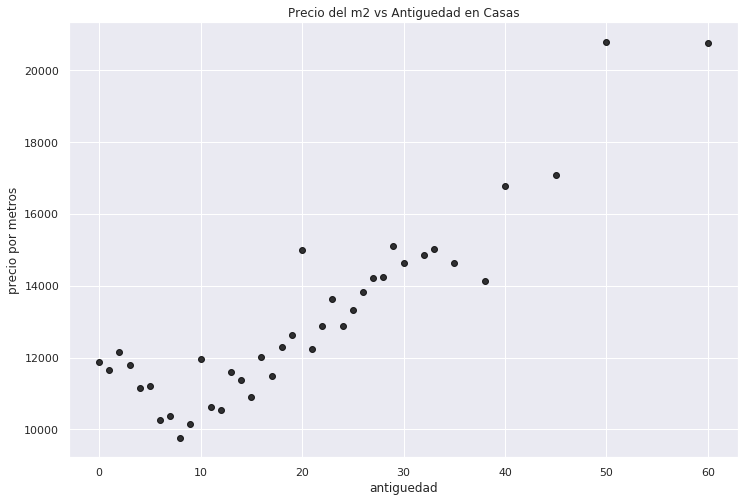

In [43]:
#Precio del metro cuadrado en Casas / Apartamentos / Casas en Condominio vs Antiguedad
sns.regplot(x=preciom2_segun_antiguedad_casa["antiguedad"], y=preciom2_segun_antiguedad_casa["precio por metros"], fit_reg = False, color = 'black')\
                            .set_title("Precio del m2 vs Antiguedad en Casas")

Text(0.5, 1.0, 'Precio del m2 vs Antiguedad en Apartamentos')

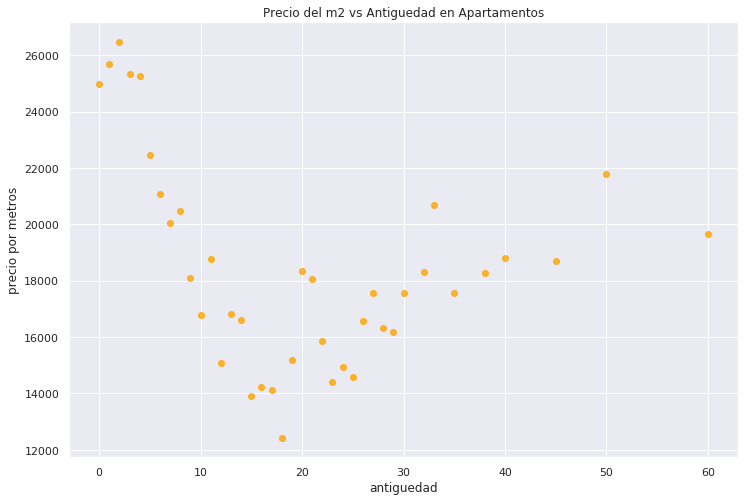

In [44]:
sns.regplot(x=preciom2_segun_antiguedad_apartamento["antiguedad"], y=preciom2_segun_antiguedad_apartamento["precio por metros"], fit_reg = False, color = 'orange')\
                            .set_title("Precio del m2 vs Antiguedad en Apartamentos")

Text(0.5, 1.0, 'Precio del m2 vs Antiguedad en Casa en condominio')

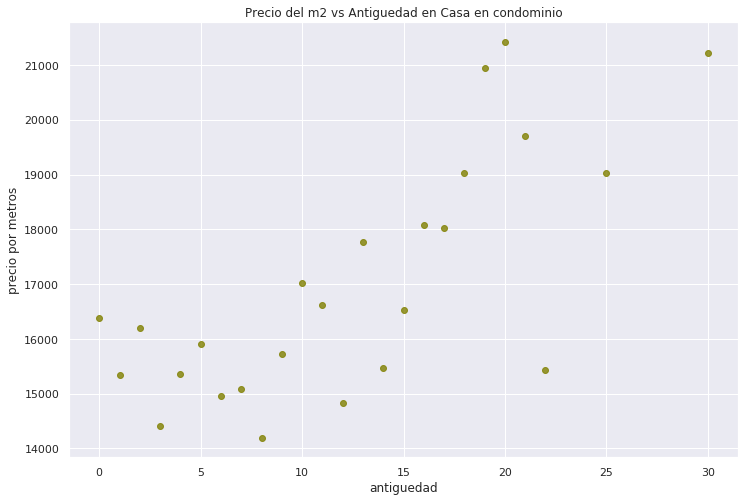

In [45]:
sns.regplot(x=preciom2_segun_antiguedad_casa_condo["antiguedad"], y=preciom2_segun_antiguedad_casa_condo["precio por metros"], fit_reg = False, color = 'olive')\
                            .set_title("Precio del m2 vs Antiguedad en Casa en condominio")

In [46]:
# Calculamos precio promedio por tipo a lo largo de los años
precio_antiguedad = df_filtrado.copy()
precio_antiguedad['antiguedad'] = 2016-precio_antiguedad['antiguedad']

precio_antiguedad = precio_antiguedad.groupby(['tipo', 'antiguedad'])['precio'].mean().reset_index()
precio_antiguedad

,tipo,antiguedad,precio
0,Apartamento,"1,936.00","903,333.33"
1,Apartamento,"1,941.00","1,350,000.00"
2,Apartamento,"1,942.00","1,250,000.00"
3,Apartamento,"1,946.00","1,712,500.00"
4,Apartamento,"1,948.00","1,250,000.00"
...,...,...,...
368,Terreno,"2,012.00","2,258,848.50"
369,Terreno,"2,013.00","1,392,348.46"
370,Terreno,"2,014.00","1,588,936.42"
371,Terreno,"2,015.00","2,086,410.47"


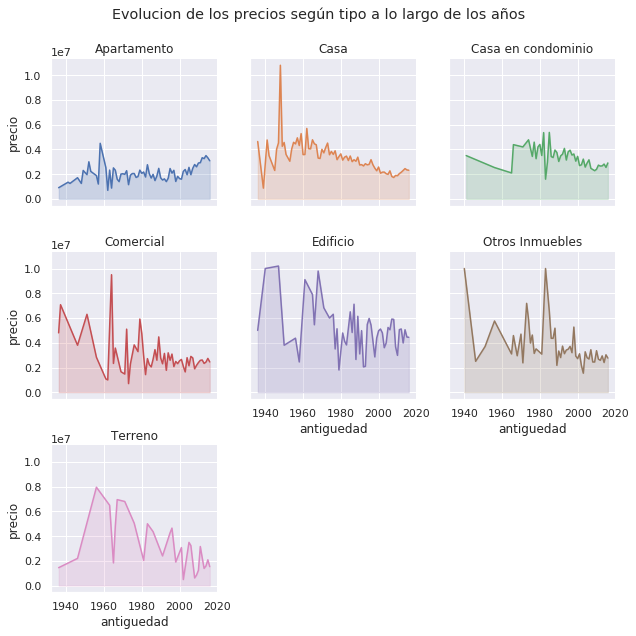

In [47]:
# Evolución del promedio de precio por tipo a lo largo de los años

g = sns.FacetGrid(precio_antiguedad, col='tipo', hue='tipo', col_wrap=3)
g = g.map(plt.plot, 'antiguedad', 'precio')
g = g.map(plt.fill_between, 'antiguedad', 'precio', alpha=0.2).set_titles("{col_name}")
g = g.set_titles("{col_name}")
plt.subplots_adjust(top=0.9)
g = g.fig.suptitle('Evolucion de los precios según tipo a lo largo de los años')
plt.show()


## Tipos a lo largo de los años (comportamiento según cada tipo)

In [48]:
tipos_antiguedad = df_filtrado.copy()
tipos_antiguedad['aux'] = 1
tipos_antiguedad['antiguedad'] = 2016-tipos_antiguedad['antiguedad']

tipos_antiguedad = tipos_antiguedad.pivot_table(values='aux', index='antiguedad', columns='tipo', aggfunc='sum', dropna=True, fill_value=0)

# Agregamos todas las angigüedades faltantes con 0
for i in range(int(min(tipos_antiguedad.index)),int(max(tipos_antiguedad.index))):
    if i not in tipos_antiguedad.index:
        tipos_antiguedad.loc[i] = 0

tipos_antiguedad = tipos_antiguedad.sort_index().cumsum(axis=0)

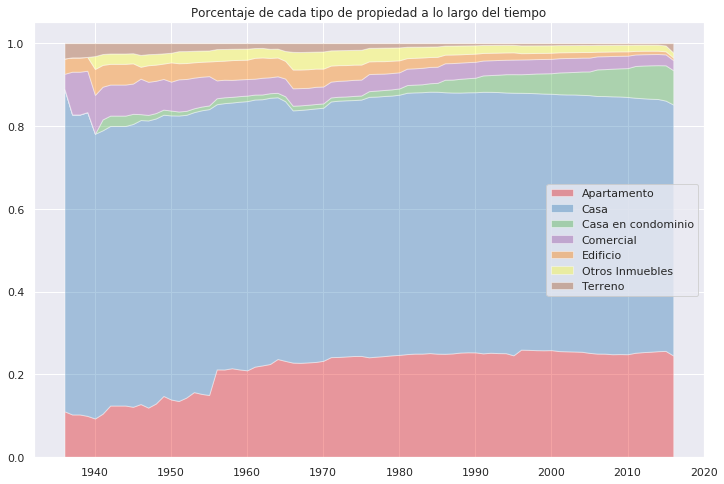

In [49]:
# Gráfico de % de cada tipo en realación al año

porcentaje_tipos_antiguedad = tipos_antiguedad.divide(tipos_antiguedad.sum(axis=1), axis=0)

plt.title('Porcentaje de cada tipo de propiedad a lo largo del tiempo')
plt.stackplot(porcentaje_tipos_antiguedad.index,*(porcentaje_tipos_antiguedad[columna] for columna in porcentaje_tipos_antiguedad.columns), labels=tipos_antiguedad.columns, colors=sns.color_palette("Set1"), alpha=0.4 )
plt.legend(loc='right')
plt.show()


______________________________________
# Posibles 'amenities'

Text(0, 0.5, 'Cantidad de propiedades')

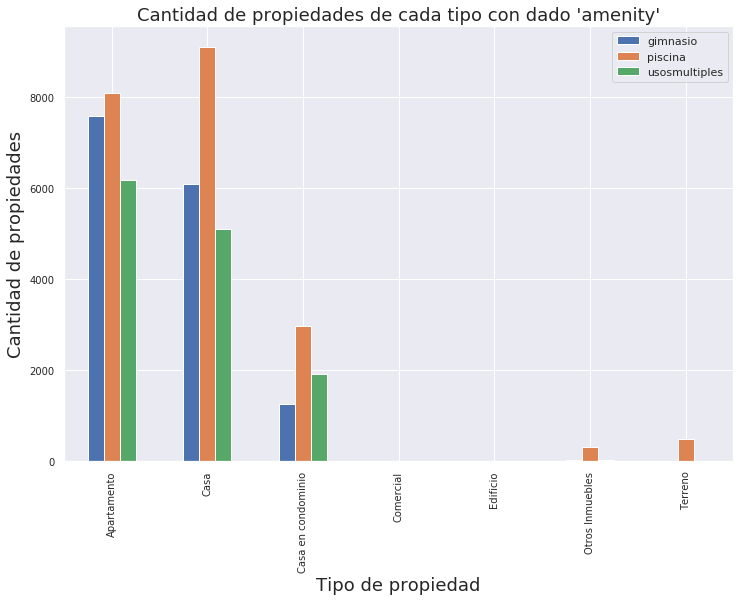

In [50]:
# Veremos qué porcentaje de cada tipo tiene cada amenity 

posibles_amenities = ['gimnasio', 'piscina', 'usosmultiples']

tipo_por_amenity = df_filtrado.groupby('tipo').agg({amenity:'sum' for amenity in posibles_amenities})
g = tipo_por_amenity.plot(kind='bar', fontsize = 10)
g.set_title("Cantidad de propiedades de cada tipo con dado 'amenity'", fontsize=18)
g.set_xlabel("Tipo de propiedad", fontsize=18)
g.set_ylabel("Cantidad de propiedades", fontsize=18)

In [51]:
tipo_por_amenity

,gimnasio,piscina,usosmultiples
tipo,,,
Apartamento,"7,591.00","8,095.00","6,187.00"
Casa,"6,105.00","9,109.00","5,099.00"
Casa en condominio,"1,262.00","2,973.00","1,907.00"
Comercial,1.00,1.00,2.00
Edificio,0.00,1.00,1.00
Otros Inmuebles,34.00,301.00,26.00
Terreno,1.00,491.00,0.00


Total de propiedades del tipo Casa con algún amenity:  16363


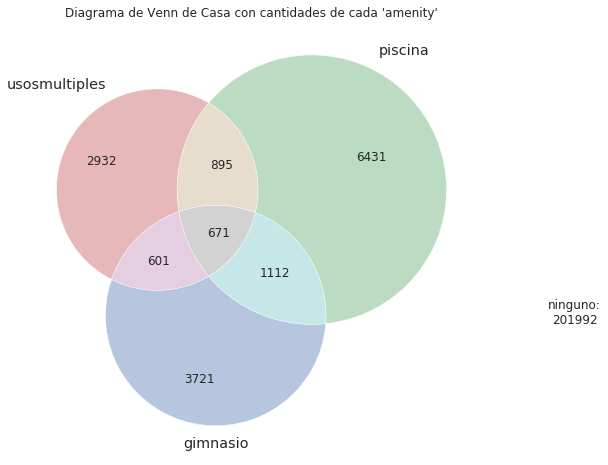

Total de propiedades del tipo Apartamento con algún amenity:  12019


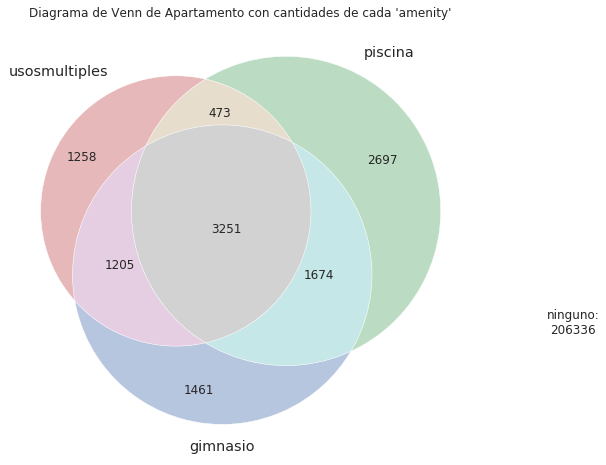

Total de propiedades del tipo Casa en condominio con algún amenity:  4391


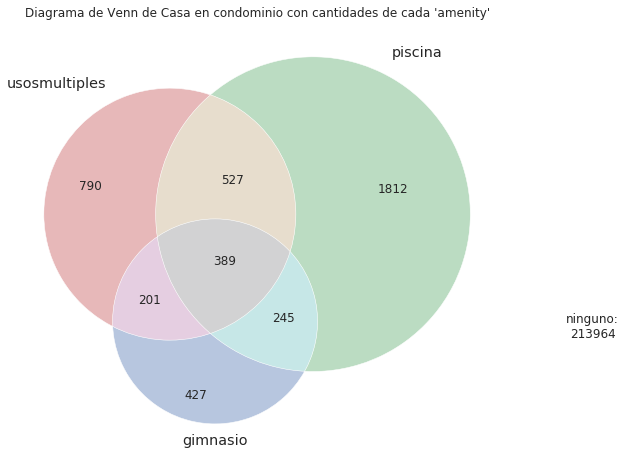

In [52]:
# Filtramos los datos que no nos interesan, es decir, los que tienen menos de 500 propiedades con todos los amenities
tipos_principales = set(['Casa', 'Apartamento', 'Casa en condominio'])
df_filtrado_amenities = df_original[[tipo in tipos_principales for tipo in df_original['tipo']]]

# Veremos primero la cantidad total de propiedades que tienen cada extra en un diagrama de conjuntos (Venn)

def contar_amenities(df):
    valor = {}
    valor['valor'] = max([df[amenity].sum() for amenity in posibles_amenities])
    return pd.Series(valor)

# Generamos un dataframe con un índice múltiple indicando si está el dado amenity o no

for tipo in ['Casa', 'Apartamento', 'Casa en condominio']:
    cantidad_amenities = df_filtrado_amenities[df_filtrado_amenities['tipo'] == tipo].groupby(posibles_amenities)[posibles_amenities].apply(contar_amenities)
    print(f'Total de propiedades del tipo {tipo} con algún amenity: ', cantidad_amenities['valor'].sum())
    cantidad_amenities.loc[False, False, False] = df_filtrado_amenities.shape[0]-cantidad_amenities['valor'].sum()
    cantidad_amenities

    # Diagrama de venn de la cantidad de cada amenity
    plt.title(f"Diagrama de Venn de {tipo} con cantidades de cada 'amenity'")
    venn3(subsets = cantidad_amenities['valor'][1:], set_labels=posibles_amenities[::-1], ax=plt.gca())
    venn3_circles(subsets = cantidad_amenities['valor'][1:], linewidth=0.5, color="white")

    plt.annotate(f'ninguno:\n{cantidad_amenities.loc[False, False, False].valor}',xy = np.array([0.72, -0.3]), xytext=(100,0),\
    ha='center', textcoords='offset points')

    plt.show()


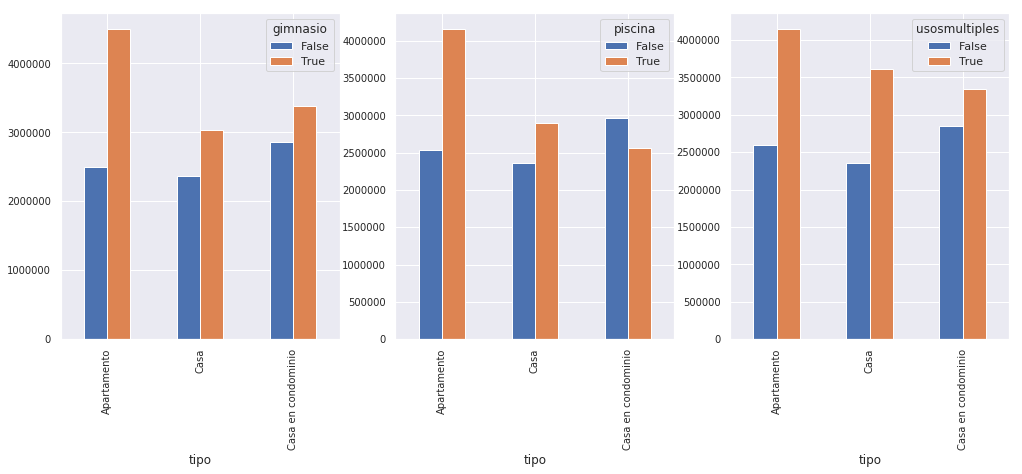

In [53]:
# Generamos un gráfico para cada amenity mostrando la diferencia de precio promedio entre cada tipo
f, axes = plt.subplots(1, 3, figsize=(17, 6), sharex=True)
i = 0
for amenity in posibles_amenities:
    df_filtrado_amenities.pivot_table(index='tipo', columns=amenity, values='precio', aggfunc='mean').plot(kind='bar', fontsize = 10, ax=axes[i])
    i+=1

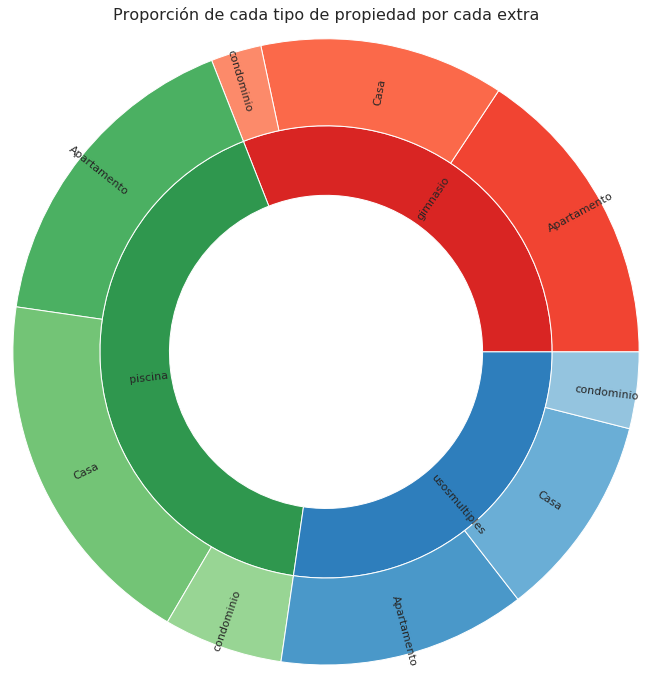

In [54]:
# Generamos un diagrama en forma de 'dona' para las cantidades de cada tipo por cada amenity\
# Eliminamos los tipos 'Edificio', 'Comercial', 'Terreno' ya que representan un porcentaje muy pequeño
tipo_por_amenity = tipo_por_amenity.loc[[x in tipos_principales for x in tipo_por_amenity.index]]

fig, ax = plt.subplots()

colores = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues]

# Anillo interior (extras)
anillo1, _ = ax.pie([tipo_por_amenity[amenity].sum() for amenity in posibles_amenities], radius=1.3,\
                    labels=posibles_amenities, labeldistance=0.7, colors=[color(0.7) for color in colores], rotatelabels=True)
plt.setp(anillo1, width=0.4, edgecolor='white')
 
# Anillo exterior (tipo por cada extra)
subgrupos = [tipo.split(' ')[-1] for i in range(3) for tipo in tipo_por_amenity.index]

anillo2, _ = ax.pie([x for columna in tipo_por_amenity.columns for x in tipo_por_amenity[columna] if x != 0], radius=1.8,\
                    labels=subgrupos, labeldistance=0.8, \
                    colors=[color(i/10) for color in colores for i in range(6,3,-1)], rotatelabels=True)
plt.setp(anillo2, width=0.5, edgecolor='white')

fig.patch.set_facecolor('white')
plt.title('Proporción de cada tipo de propiedad por cada extra',pad=115, fontsize=16)
plt.margins(0,0) 
plt.show()



______________________________________

# **Analisis segun cantidad de banios, habitaciones, garages**

In [55]:
#Analisis de cantidad de banios y habitaciones

#Sera efectuado unicamente sobre Casas, Apartamentos y Casa en condominio
df_filtrado_cantidades = df_filtrado.loc[[x in individuales for x in df_filtrado['tipo']]]

#Me quedo con aquellos que tengan al menos una habitacion
df_filtrado_cantidades = df_filtrado_cantidades.loc[df_filtrado_cantidades['cant_habitaciones'] > 0]

In [56]:
habitaciones_grouped = df_filtrado_cantidades.groupby('cant_habitaciones').agg({'id' : 'count'})
habitaciones_grouped.columns = ['cantidad_propiedades']
habitaciones_grouped.reset_index(inplace = True)
habitaciones_grouped['cant_habitaciones'] = habitaciones_grouped['cant_habitaciones'].apply(lambda x: x if x < 6 else "6+")
habitaciones_grouped = habitaciones_grouped.groupby('cant_habitaciones').agg({'cantidad_propiedades':'sum'})
habitaciones_grouped


,cantidad_propiedades
cant_habitaciones,
1.0,4587
2.0,56868
3.0,120861
4.0,24610
5.0,4408
6+,2777


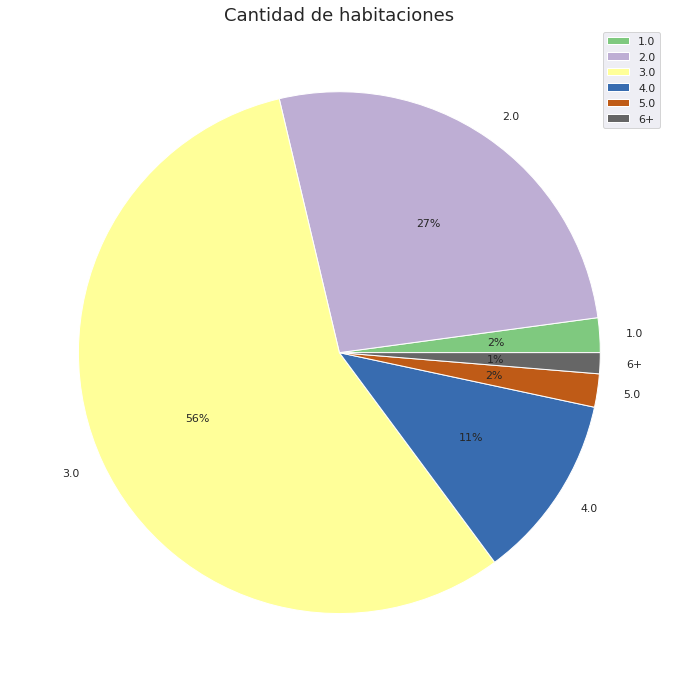

In [57]:
habitaciones_grouped.plot(kind='pie', figsize=(12,12),cmap='Accent',fontsize=11, autopct='%1.0f%%',y = 'cantidad_propiedades')
plt.title('Cantidad de habitaciones', fontsize = 18)
plt.ylabel('')
plt.show();

In [58]:
#Precio vs cantidad de habitaciones
precio_por_habitaciones = df_filtrado_cantidades.groupby('cant_habitaciones').agg({'precio' : 'mean'})
precio_por_habitaciones.reset_index(inplace = True)
precio_por_habitaciones.columns = ['cantidad_de_habitaciones', 'precio_promedio']

Text(0.5, 1.0, 'Precio promedio vs cantidad de habitaciones')

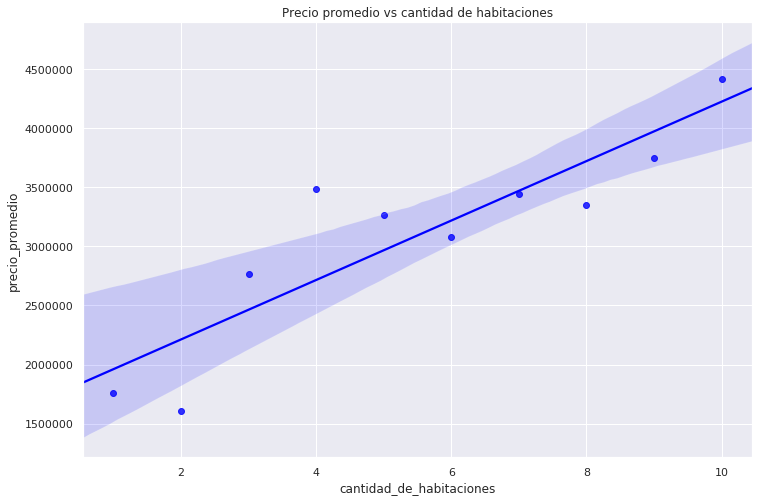

In [59]:
sns.regplot(x=precio_por_habitaciones["cantidad_de_habitaciones"], y=precio_por_habitaciones["precio_promedio"], color = 'blue')\
                .set_title("Precio promedio vs cantidad de habitaciones")

In [60]:
#Precio promedio vs cantidad de banos

#Filtro aquellos que no tengan banos
df_filtrado_cantidades = df_filtrado_cantidades.loc[df_filtrado_cantidades['cant_banios'] > 0]

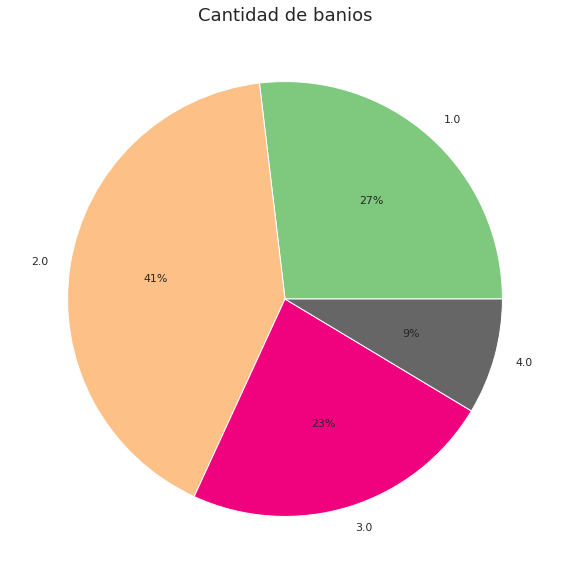

In [61]:
banios_grouped = df_filtrado_cantidades.groupby('cant_banios').size().plot(kind='pie', figsize=(10,10),autopct='%1.0f%%',cmap='Accent',fontsize=11)
plt.title('Cantidad de banios', fontsize = 18)
plt.ylabel('')
plt.show();

Text(0.5, 1.0, 'Precio promedio vs cantidad de banos')

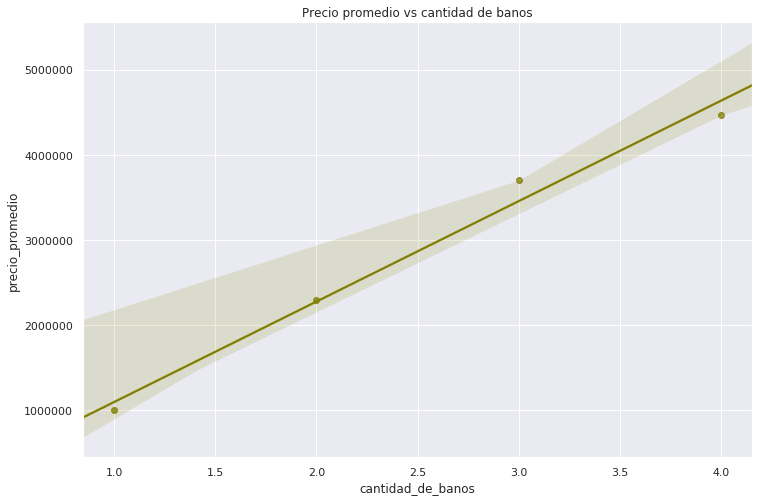

In [62]:
#Agrupo por cantidad de banos y calculo precio promedio
precio_por_banos = df_filtrado_cantidades.groupby('cant_banios').agg({'precio' : 'mean'})
precio_por_banos.reset_index(inplace = True)
precio_por_banos.columns = ['cantidad_de_banos', 'precio_promedio']

sns.regplot(x=precio_por_banos["cantidad_de_banos"], y=precio_por_banos["precio_promedio"], color = 'olive')\
                .set_title("Precio promedio vs cantidad de banos")

In [63]:
#Precio promedio vs cantidad de garages

#Filtro aquellos que no tengan garages
df_filtrado_cantidades = df_filtrado_cantidades.loc[df_filtrado_cantidades['cant_garages'] > 0]

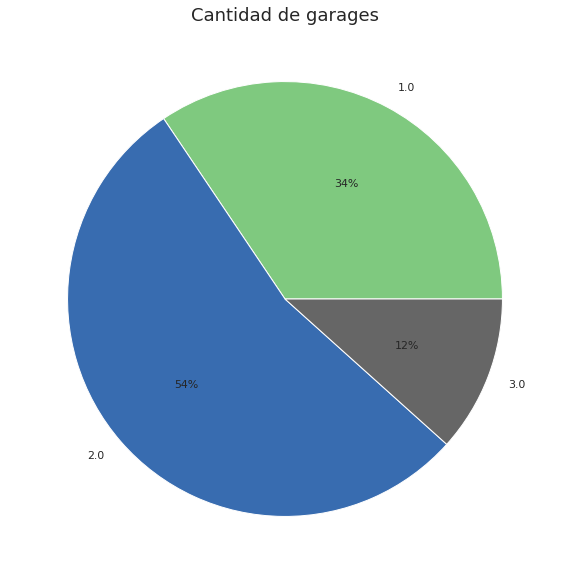

In [64]:
banios_grouped = df_filtrado_cantidades.groupby('cant_garages').size().plot(kind='pie', figsize=(10,10),autopct='%1.0f%%',cmap='Accent',fontsize=11)
plt.title('Cantidad de garages', fontsize = 18)
plt.ylabel('')
plt.show();

Text(0.5, 1.0, 'Precio promedio vs cantidad de garages')

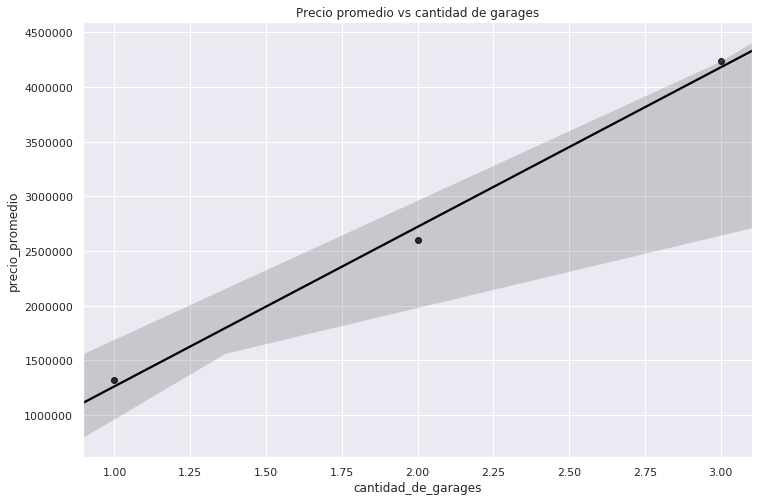

In [65]:
#Agrupo por cantidad de garages y calculo precio promedio
precio_por_garages = df_filtrado_cantidades.groupby('cant_garages').agg({'precio' : 'mean'})
precio_por_garages.reset_index(inplace = True)
precio_por_garages.columns = ['cantidad_de_garages', 'precio_promedio']

sns.regplot(x=precio_por_garages["cantidad_de_garages"], y=precio_por_garages["precio_promedio"], color = 'black')\
                .set_title("Precio promedio vs cantidad de garages")

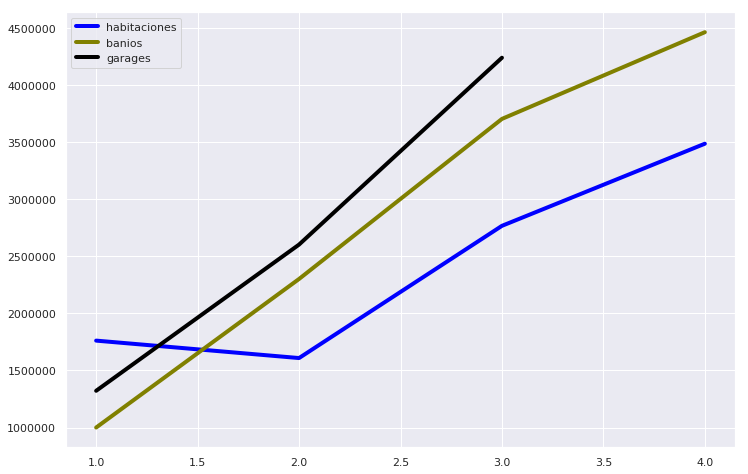

In [66]:
#Analizo en conjunto el precio vs cantidad_de_habitaciones, cantidad_de_banios, cantidad_de_garages

#Quito las publicaciones con mas de cuatro habitaciones asi ajusta la interseccion de las 3 categorias. La tendencia, de todas formas, ya se analizo por separado

precio_por_habitaciones = precio_por_habitaciones.drop([x for x in range(4, 10)])

plt.plot( 'cantidad_de_habitaciones', 'precio_promedio', data=precio_por_habitaciones, marker='', markerfacecolor='blue', color='blue', linewidth=4, label = "habitaciones")
plt.plot( 'cantidad_de_banos', 'precio_promedio', data=precio_por_banos, marker='', color='olive', linewidth=4, label = "banios")
plt.plot( 'cantidad_de_garages', 'precio_promedio', data=precio_por_garages, marker='', color='black', linewidth=4, label="garages")
plt.legend()

______________________________________
# Analizar el precio y relacion con metros

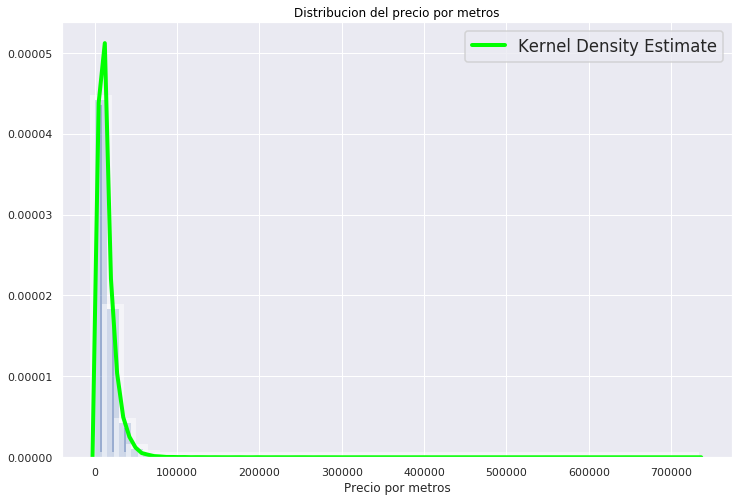

In [67]:
#analiazando distribucion generar de precio por metros
figure = plt.figure()

plt.title('Distribucion del precio por metros', color = 'black')

sns.set_context('talk')
sns.set_context('talk')
sns.distplot(df_filtrado['precio por metros'],axlabel = "Precio por metros",\
            kde_kws={"color": "lime", "lw":4, "label": "Kernel Density Estimate"},\
            hist_kws={"linewidth": 10, "alpha": 0.5, "color": "b"})
sns.set(rc={'figure.figsize':(12,8)})

KeyboardInterrupt: 

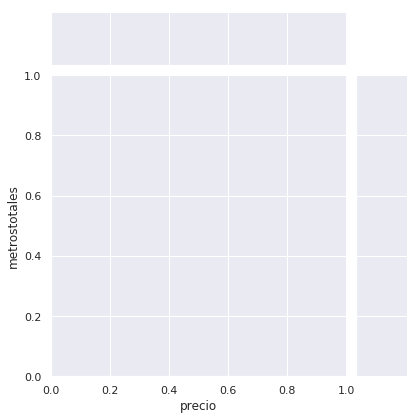

In [68]:
#distribucion de precio y metros totales
sns.jointplot(x=df_filtrado["precio"], y=df_filtrado["metrostotales"], kind = 'kde', s=200, color='m', edgecolor="skyblue", linewidth=2,title='Distribucion de precio con metrostotales')


______________________________________
# Analizar precio por metros con ciudades

In [ ]:
#analizando top 10 ciudades del pais con mayor precio por metros
df_ciudad = df_filtrado.groupby('ciudad').agg({'precio por metros':'mean'})
df_ciudad_top10 = df_ciudad[['precio por metros']].sort_values('precio por metros', ascending = False)[:10]
df_ciudad_top10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0, 0, 0.75),title = 'Top10 promedio de precio por metros de ciudad del pais' )
df_ciudad_top10


In [ ]:
#analizando bottom 10 ciudades del pais con menor precio por metros
df_ciudad_bottom10 = df_ciudad[['precio por metros']].sort_values('precio por metros', ascending = True)[0:10]
df_ciudad_bottom10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.75, 0.75, 0),title = 'Bottom10 promedio de precio por metros de ciudad del pais' )
df_ciudad_bottom10

In [ ]:
data=pd.read_csv('files/ciudad_20.csv',sep = ',')
m = folium.Map(location=[20, -95], tiles="OpenStreetMap", zoom_start=6)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*30,
      color='blue',
      fill=True,
      fill_color='blue'
   ).add_to(m)
 
# Save it as html
m.save('files/mymap_pais.html')
m

## con ciudades de Distrito Federal

In [ ]:
#ya que hay menos de 20 ciudades en distrito federal, se presenta en un grafico
df_distritofederal = df_filtrado[df_filtrado.provincia == 'Distrito Federal']
df_ciudad_df = df_distritofederal[['provincia','ciudad','precio por metros']]
df_ciudad_df = df_ciudad_df.groupby(['provincia','ciudad']).agg({'precio por metros':'mean'})
df_ciudad_df.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.75, 0.25, 0.75),title = 'Promedio de precio por metros de cada ciudad en Distrito Federal')

In [ ]:
data=pd.read_csv('files/ciudad_df.csv',sep = ',')
m = folium.Map(location=[19.35, -99.2], tiles="OpenStreetMap", zoom_start=11)

for i in range(0,len(data)):
    folium.Circle(
        location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
        popup=data.iloc[i]['ciudad'],
        radius=data.iloc[i]['precio']*5,
        color='crimson',
        fill=True,
        fill_color='crimson'
   ).add_to(m)
 
# Save it as html
m.save('files/mymap_df.html')
m

## con ciudades de edo. mexico

In [ ]:
df_edomexico = df_filtrado[df_filtrado.provincia == 'Edo. de México']
df_ciudad_em = df_edomexico[['ciudad','precio por metros']]
df_ciudad_em = df_ciudad_em.groupby('ciudad').agg({'precio por metros':'mean'})

df_ciudad_em_top10 = df_ciudad_em[['precio por metros']].sort_values('precio por metros', ascending = False)[:10]
df_ciudad_em_top10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.25, 0.85, 0.75),title = 'Top10 promedio de precio por metros de ciudad en Edo. de México')
df_ciudad_em_top10

In [ ]:
df_ciudad_em_bottom10 = df_ciudad_em[['precio por metros']].sort_values('precio por metros', ascending = True)[0:10]
df_ciudad_em_bottom10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.75, 0.75, 0.25),title = 'Bottom10 promedio de precio por metros de ciudad en Edo. de México')
df_ciudad_em_bottom10

In [ ]:
data=pd.read_csv('files/ciudad_em.csv',sep = ',')
m = folium.Map(location=[19.35, -99.2], tiles="OpenStreetMap", zoom_start=9)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*20,
      color='red',
      fill=True,
      fill_color='red'
   ).add_to(m)
 
# Save it as html
m.save('files/mymap_em.html')
m

## con ciudades de Jalisco

In [ ]:
df_jalisco = df_filtrado[df_filtrado.provincia == 'Jalisco']
df_ciudad_ja = df_jalisco[['ciudad','precio por metros']]
df_ciudad_ja = df_ciudad_ja.groupby('ciudad').agg({'precio por metros':'mean'})

In [ ]:
df_ciudad_ja_top10 = df_ciudad_ja[['precio por metros']].sort_values('precio por metros', ascending = False)[:10]
df_ciudad_ja_top10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.75, 0.25, 0.25),title = 'Top10 promedio de precio por metros de ciudad en Jalisco')
df_ciudad_ja_top10

In [ ]:
df_ciudad_ja_bottom10 = df_ciudad_ja[['precio por metros']].sort_values('precio por metros', ascending = True)[0:10]
df_ciudad_ja_bottom10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.5, 0.5, 0.25),title = 'Top10 promedio de precio por metros de ciudad en Jalisco')
df_ciudad_ja_bottom10

In [ ]:
data=pd.read_csv('files/ciudad_ja.csv',sep = ',')
m = folium.Map(location=[20, -103.2], tiles="OpenStreetMap", zoom_start=8)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*30,
      color='Purple',
      fill=True,
      fill_color='Purple'
   ).add_to(m)
 
# Save it as html
m.save('files/mymap_ja.html')
m

## con ciudades de Querétaro

In [ ]:
#son menor que 20 ciudades
df_queretaro  = df_filtrado[df_filtrado.provincia == 'Querétaro']
df_ciudad_qe = df_queretaro [['provincia','ciudad','precio por metros']]
df_ciudad_qe = df_ciudad_qe.groupby(['provincia','ciudad']).agg({'precio por metros':'mean'})
df_ciudad_qe.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0, 0, 0.75),title = 'Promedio de precio por metros de cada ciudad en Querétaro')
df_ciudad_qe

In [ ]:
data=pd.read_csv('files/ciudad_qe.csv',sep = ',')
m = folium.Map(location=[20.87, -100], tiles="OpenStreetMap", zoom_start=9)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*30,
      color='navy',
      fill=True,
      fill_color='navy'
   ).add_to(m)
 
# Save it as html
m.save('files/mymap_qe.html')
m

## con ciudades de Nuevo León

In [ ]:
df_nl = df_filtrado[df_filtrado.provincia == 'Nuevo León']
df_ciudad_nl = df_nl [['ciudad','precio por metros']]
df_ciudad_nl = df_ciudad_nl.groupby('ciudad').agg({'precio por metros':'mean'})

In [ ]:
df_ciudad_nl_top10 = df_ciudad_nl[['precio por metros']].sort_values('precio por metros', ascending = False)[:10]
df_ciudad_nl_top10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0, 0.75, 0.25),title = 'Top10 promedio de precio por metros de ciudad en Nuevo León ')
df_ciudad_nl_top10

In [ ]:
df_ciudad_nl_bottom10 = df_ciudad_nl[['precio por metros']].sort_values('precio por metros', ascending = True)[0:10]
df_ciudad_nl_bottom10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.75, 0.5, 0),title = 'Top10 promedio de precio por metros de ciudad en Nuevo León')
df_ciudad_nl_bottom10

In [ ]:
data=pd.read_csv('files/ciudad_nl.csv',sep = ',')
m = folium.Map(location=[26, -100], tiles="OpenStreetMap", zoom_start=7)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*40,
      color='navy',
      fill=True,
      fill_color='navy'
   ).add_to(m)
 
# Save it as html
m.save('files/mymap_nl.html')
m

______________________________________
# Analizando casas

In [ ]:
# top 10 promedio de precio por metros de casa mas caro del pais
df_casa = df_filtrado[df_filtrado.tipo =='Casa']
df_casa = df_casa.groupby('ciudad').agg({'precio por metros':'mean'})
df_casa_top10 = df_casa[['precio por metros']].sort_values('precio por metros', ascending = False)[:10]
df_casa_top10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0, 0, 0.75),title = 'Top10 promedio de precio por metros de casa de ciudad del pais' )
df_casa_top10

In [ ]:
df_casa = df_filtrado[df_filtrado.tipo =='Casa']
df_casa = df_casa.groupby('ciudad').agg({'precio por metros':'mean'})
df_casa_bottom10 = df_casa[['precio por metros']].sort_values('precio por metros', ascending = True)[0:10]
df_casa_bottom10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0, 0, 0.75),title = 'Bottom10 promedio de precio por metros de casa de ciudad del pais' )
df_casa_bottom10

In [ ]:
data=pd.read_csv('files/ciudad_casa_20.csv',sep = ',')
m = folium.Map(location=[20, -95], tiles="OpenStreetMap", zoom_start=5)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*0.6,
      color='blue',
      fill=True,
      fill_color='blue'
   ).add_to(m)
 
# Save it as html
m.save('files/mymap_casa_20.html')
m

In [ ]:
df_distritofederalcasa = df_filtrado.loc[(df_filtrado.provincia == 'Distrito Federal')&(df_filtrado.tipo =='Casa')]
df_ciudad_df = df_distritofederalcasa[['provincia','ciudad','precio por metros']]
df_ciudad_df = df_ciudad_df.groupby(['provincia','ciudad']).agg({'precio por metros':'mean'})
df_ciudad_df.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.75, 0.25, 0.75),title = 'Promedio de precio por metros de cada ciudad en Distrito Federal')
df_ciudad_df

In [ ]:
data=pd.read_csv('files/ciudad_df_casa.csv',sep = ',')
m = folium.Map(location=[19.35, -99.2], tiles="OpenStreetMap", zoom_start=11)

for i in range(0,len(data)):
    folium.Circle(
        location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
        popup=data.iloc[i]['ciudad'],
        radius=data.iloc[i]['precio']/10,
        color='crimson',
        fill=True,
        fill_color='crimson'
   ).add_to(m)
 
# Save it as html
m.save('files/mymap_df_casa.html')
m

In [ ]:
df_edomexico = df_filtrado[(df_filtrado.provincia == 'Edo. de México')&(df_filtrado.tipo =='Casa')]
df_ciudad_em = df_edomexico[['ciudad','precio por metros']]
df_ciudad_em = df_ciudad_em.groupby('ciudad').agg({'precio por metros':'mean'})

df_ciudad_em_top10 = df_ciudad_em[['precio por metros']].sort_values('precio por metros', ascending = False)[:10]
df_ciudad_em_top10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.25, 0.85, 0.75),title = 'Top10 promedio de precio por metros de ciudad en Edo. de México')
df_ciudad_em_top10

In [ ]:
df_ciudad_em_bottom10 = df_ciudad_em[['precio por metros']].sort_values('precio por metros', ascending = True)[0:10]
df_ciudad_em_bottom10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.75, 0.75, 0.25),title = 'Bottom10 promedio de precio por metros de ciudad en Edo. de México')
df_ciudad_em_bottom10

In [ ]:
data=pd.read_csv('files/ciudad_em_casa.csv',sep = ',')
m = folium.Map(location=[19.35, -99.2], tiles="OpenStreetMap", zoom_start=9)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*0.4,
      color='red',
      fill=True,
      fill_color='red'
   ).add_to(m)
 
# Save it as html
m.save('files/mymap_em_casa.html')
m

In [ ]:
df_jalisco = df_filtrado.loc[(df_filtrado.provincia == 'Jalisco')&(df_filtrado.tipo == 'Casa')]
df_ciudad_ja = df_jalisco[['ciudad','precio por metros']]
df_ciudad_ja = df_ciudad_ja.groupby('ciudad').agg({'precio por metros':'mean'})
df_ciudad_ja_top10 = df_ciudad_ja[['precio por metros']].sort_values('precio por metros', ascending = False)[:10]
df_ciudad_ja_top10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.75, 0.25, 0.25),title = 'Top10 promedio de precio por metros de ciudad en Jalisco')
df_ciudad_ja_top10

In [ ]:
df_ciudad_ja_bottom10 = df_ciudad_ja[['precio por metros']].sort_values('precio por metros', ascending = True)[0:10]
df_ciudad_ja_bottom10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.5, 0.5, 0.25),title = 'Bottom10 promedio de precio por metros de ciudad en Jalisco')
df_ciudad_ja_bottom10

In [ ]:
data=pd.read_csv('files/ciudad_ja_casa.csv',sep = ',')
m = folium.Map(location=[20, -103.2], tiles="OpenStreetMap", zoom_start=8)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*0.6,
      color='Purple',
      fill=True,
      fill_color='Purple'
   ).add_to(m)
 
# Save it as html
m.save('files/mymap_ja_casa.html')
m

In [ ]:
df_queretaro  = df_filtrado.loc[(df_filtrado.provincia == 'Querétaro')&(df_filtrado.tipo == 'Casa')]
df_ciudad_qe = df_queretaro [['provincia','ciudad','precio por metros']]
df_ciudad_qe = df_ciudad_qe.groupby(['provincia','ciudad']).agg({'precio por metros':'mean'})
df_ciudad_qe.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0, 0, 0.75),title = 'Promedio de precio por metros de cada ciudad en Querétaro')
df_ciudad_qe

In [ ]:
data=pd.read_csv('files/ciudad_qe_casa.csv',sep = ',')
m = folium.Map(location=[20.87, -100], tiles="OpenStreetMap", zoom_start=9)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*0.6,
      color='navy',
      fill=True,
      fill_color='navy'
   ).add_to(m)
 
# Save it as html
m.save('files/mymap_qe_casa.html')
m

In [ ]:
df_nl = df_filtrado[(df_filtrado.provincia == 'Nuevo León')&(df_filtrado.tipo == 'Casa')]
df_ciudad_nl = df_nl [['ciudad','precio por metros']]
df_ciudad_nl = df_ciudad_nl.groupby('ciudad').agg({'precio por metros':'mean'})
df_ciudad_nl_top10 = df_ciudad_nl[['precio por metros']].sort_values('precio por metros', ascending = False)[:10]
df_ciudad_nl_top10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0, 0.75, 0.25),title = 'Top10 promedio de precio por metros de ciudad en Nuevo León ')
df_ciudad_nl_top10

In [ ]:
df_ciudad_nl_bottom10 = df_ciudad_nl[['precio por metros']].sort_values('precio por metros', ascending = True)[0:10]
df_ciudad_nl_bottom10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.75, 0.5, 0),title = 'Bottom 10 promedio de precio por metros de ciudad en Nuevo León')
df_ciudad_nl_bottom10

In [ ]:
data=pd.read_csv('files/ciudad_nl_casa.csv',sep = ',')
m = folium.Map(location=[26, -100], tiles="OpenStreetMap", zoom_start=7)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*0.8,
      color='navy',
      fill=True,
      fill_color='navy'
   ).add_to(m)
 
# Save it as html
m.save('files/mymap_nl_casa.html')
m

______________________________________
# Analizando apartamentos

In [ ]:
df_apartamento = df_filtrado[df_filtrado.tipo =='Apartamento']
df_apa = df_apartamento.groupby('ciudad').agg({'precio por metros':'mean'})
df_apa_top10 = df_apa[['precio por metros']].sort_values('precio por metros', ascending = False)[:10]
df_apa_top10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0, 0, 0.75),title = 'Top10 promedio de precio por metros de casa de ciudad del pais' )
df_apa_top10

In [ ]:

df_apa_bottom10 = df_apa[['precio por metros']].sort_values('precio por metros', ascending = True)[0:10]
df_apa_bottom10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0, 0, 0.75),title = 'Bottom10 promedio de precio por metros de casa de ciudad del pais' )
df_apa_bottom10

In [ ]:
data=pd.read_csv('files/ciudad_apa_20.csv',sep = ',')
m = folium.Map(location=[20, -95], tiles="OpenStreetMap", zoom_start=5)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*0.6,
      color='blue',
      fill=True,
      fill_color='blue'
   ).add_to(m)
 
# Save it as html
m.save('files/mymap_apa_20.html')
m

In [ ]:
df_distritofederalapa = df_filtrado.loc[(df_filtrado.provincia == 'Distrito Federal')&(df_filtrado.tipo =="Apartamento")]
df_ciudad_df = df_distritofederalapa[['provincia','ciudad','precio por metros']]
df_ciudad_df = df_ciudad_df.groupby(['provincia','ciudad']).agg({'precio por metros':'mean'})
df_ciudad_df.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.75, 0.25, 0.75),title = 'Promedio de precio por metros de cada ciudad en Distrito Federal')
df_ciudad_df

In [ ]:
data=pd.read_csv('files/ciudad_df_apa.csv',sep = ',')
m = folium.Map(location=[19.35, -99.2], tiles="OpenStreetMap", zoom_start=11)

for i in range(0,len(data)):
    folium.Circle(
        location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
        popup=data.iloc[i]['ciudad'],
        radius=data.iloc[i]['precio']/10,
        color='crimson',
        fill=True,
        fill_color='crimson'
   ).add_to(m)
 
# Save it as html
m.save('files/mymap_df_apa.html')
m

In [ ]:
df_edomexico = df_filtrado[(df_filtrado.provincia == 'Edo. de México')&(df_filtrado.tipo =='Apartamento')]
df_ciudad_em = df_edomexico[['ciudad','precio por metros']]
df_ciudad_em = df_ciudad_em.groupby('ciudad').agg({'precio por metros':'mean'})

df_ciudad_em_top10 = df_ciudad_em[['precio por metros']].sort_values('precio por metros', ascending = False)[:10]
df_ciudad_em_top10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.25, 0.85, 0.75),title = 'Top10 promedio de precio por metros de ciudad en Edo. de México')
df_ciudad_em_top10

In [ ]:
df_ciudad_em_bottom10 = df_ciudad_em[['precio por metros']].sort_values('precio por metros', ascending = True)[0:10]
df_ciudad_em_bottom10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.75, 0.75, 0.25),title = 'Bottom10 promedio de precio por metros de ciudad en Edo. de México')
df_ciudad_em_bottom10

In [ ]:
data=pd.read_csv('files/ciudad_em_apa.csv',sep = ',')
m = folium.Map(location=[19.35, -99.2], tiles="OpenStreetMap", zoom_start=9)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*0.4,
      color='red',
      fill=True,
      fill_color='red'
   ).add_to(m)
 
# Save it as html
m.save('files/mymap_em_apa.html')
m

In [ ]:
df_jalisco = df_filtrado.loc[(df_filtrado.provincia == 'Jalisco')&(df_filtrado.tipo == 'Apartamento')]
df_ciudad_ja = df_jalisco[['ciudad','precio por metros']]
df_ciudad_ja = df_ciudad_ja.groupby('ciudad').agg({'precio por metros':'mean'})
df_ciudad_ja_top10 = df_ciudad_ja[['precio por metros']].sort_values('precio por metros', ascending = False)[:10]
df_ciudad_ja_top10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.75, 0.25, 0.25),title = 'promedio de precio por metros de ciudad en Jalisco')
df_ciudad_ja_top10

In [ ]:
data=pd.read_csv('files/ciudad_ja_apa.csv',sep = ',')
m = folium.Map(location=[20, -103.2], tiles="OpenStreetMap", zoom_start=8)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*0.6,
      color='Purple',
      fill=True,
      fill_color='Purple'
   ).add_to(m)
 
# Save it as html
m.save('files/mymap_ja_apa.html')
m

In [ ]:
df_queretaro  = df_filtrado.loc[(df_filtrado.provincia == 'Querétaro')&(df_filtrado.tipo == 'Apartamento')]
df_ciudad_qe = df_queretaro [['provincia','ciudad','precio por metros']]
df_ciudad_qe = df_ciudad_qe.groupby(['provincia','ciudad']).agg({'precio por metros':'mean'})
df_ciudad_qe.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0, 0, 0.75),title = 'Promedio de precio por metros de cada ciudad en Querétaro')
df_ciudad_qe

In [ ]:
data=pd.read_csv('files/ciudad_qe_apa.csv',sep = ',')
m = folium.Map(location=[20.87, -100], tiles="OpenStreetMap", zoom_start=9)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*0.6,
      color='navy',
      fill=True,
      fill_color='navy'
   ).add_to(m)
 
# Save it as html
m.save('files/mymap_qe_apa.html')
m

In [ ]:
df_nl = df_filtrado[(df_filtrado.provincia == 'Nuevo León')&(df_filtrado.tipo == 'Apartamento')]
df_ciudad_nl = df_nl [['ciudad','precio por metros']]
df_ciudad_nl = df_ciudad_nl.groupby('ciudad').agg({'precio por metros':'mean'})
df_ciudad_nl_top10 = df_ciudad_nl[['precio por metros']].sort_values('precio por metros', ascending = False)[:11]
df_ciudad_nl_top10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0, 0.75, 0.25),title = 'Promedio de precio por metros de ciudad en Nuevo León ')
df_ciudad_nl_top10

In [ ]:
data=pd.read_csv('files/ciudad_nl_apa.csv',sep = ',')
m = folium.Map(location=[26, -100], tiles="OpenStreetMap", zoom_start=7)

for i in range(0,len(data)):
   folium.Circle(
      location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
      popup=data.iloc[i]['ciudad'],
      radius=data.iloc[i]['precio']*0.8,
      color='navy',
      fill=True,
      fill_color='navy'
   ).add_to(m)
 
# Save it as html
m.save('files/mymap_nl_apa.html')
m

______________________________________
# **Análisis por provincia**

### **Cantidad de publicaciones por provincia**

In [ ]:
state_geo = 'files/mexican_states.json'

In [ ]:
#Veo cuantas publicaciones hay por estado

#Primero, filtro aquellos que no tengan info del estado:
df_filtrado_provincias = df_filtrado.loc[~df_filtrado['provincia'].isnull()]

In [ ]:
#Reemplazo los nombres por los del GeoJSON
df_filtrado_provincias['provincia'] = df_filtrado_provincias['provincia'].replace({'Edo. de México' : 'Mexico',
                                               'Querétaro' : 'Queretaro',
                                               'Nuevo León' : 'Nuevo Leon',
                                               'San luis Potosí' : 'San Luis Potosi',
                                               'Yucatán' : 'Yucatan',
                                               'Baja California Norte' : 'Baja California',
                                               'Michoacán' : 'Michoacan'})

In [ ]:
#Sumo la cantidad de publicaciones por provincia
cantidad_por_provincia = df_filtrado_provincias.groupby('provincia').agg({'id' : 'count'})
cantidad_por_provincia.reset_index(inplace = True)
cantidad_por_provincia.columns = ['provincia', 'cantidad_de_publicaciones']

In [ ]:
FILL_OPACITY = 0.7
LINE_OPACITY = 1
LOCATION = [22, -101]
ZOOM_START = 5
MAP_WIDTH = '75%'
MAP_HEIGHT = '75%'

def choropleth(lista_datos, color, name, datos, nombre_archivo):
    #Inicializo mapa con folium
    mapa = folium.Map(location=LOCATION, zoom_start=ZOOM_START, width = MAP_WIDTH, height = MAP_HEIGHT)
    
    folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=datos,
    columns=lista_datos,
    key_on='properties.admin_name',
    fill_color=color,
    fill_opacity=FILL_OPACITY,
    line_opacity=LINE_OPACITY,
    legend_name=name).add_to(mapa)


    mapa.save(('files/' + nombre_archivo + '.html')) 

    folium.LayerControl().add_to(mapa)
    
    return mapa


In [ ]:
mapa_cantidad_por_provincia = choropleth(['provincia', 'cantidad_de_publicaciones'], 'YlGn', 'Cantidad de publicaciones por Provincia', cantidad_por_provincia, 'cantidad_por_provincia')
mapa_cantidad_por_provincia

## **Poblacion por provincia**

In [ ]:
df_provincias = pd.read_csv('files/datos_provincias.csv')
df_provincias.columns = ['provincia', 'pbi per capita', 'poblacion']

In [ ]:
mapa_poblacion_por_provincia = choropleth(['provincia', 'poblacion'], 'OrRd', 'Poblacion por Provincia', df_provincias, 'poblacion_por_provincia')
mapa_poblacion_por_provincia

## **Provincias más caras** (precio por m2 promedio por provincia)

In [ ]:
#Analizo el precio por m2 promedio por provincia

#Sera efectuado unicamente sobre Casas, Apartamentos y Casa en condominio

df_filtrado_provincias = df_filtrado_provincias.loc[(df_filtrado['tipo'] != 'Otros') | (df_filtrado['tipo'] != 'Terreno')]

#Me quedo con aquellas cuyo precio sea mayor a cero

df_filtrado_provincias = df_filtrado_provincias.loc[df_filtrado_provincias['precio por metros'] > 0]

In [ ]:
#Calculo el precio promedio por provincia
precio_promedio_provincia = df_filtrado_provincias.groupby('provincia').agg({'precio por metros' : 'mean'})
precio_promedio_provincia.reset_index(inplace = True)
precio_promedio_provincia.columns = ['provincia', 'precio_por_m2_mean']

In [ ]:
mapa_precio_provincia = choropleth(['provincia', 'precio_por_m2_mean'], 'YlGn', 'Precio promedio por m2 por Provincia', precio_promedio_provincia, 'precio_promedio_por_provincia')
mapa_precio_provincia

## **PBI per capita por provincia**

In [ ]:
mapa_pbipc_por_provincia = choropleth(['provincia', 'pbi per capita'], 'OrRd', 'PBI per capita por Provincia', df_provincias, 'pbi_por_provincia')
mapa_pbipc_por_provincia

In [ ]:
#Las cinco provincias cuyo precio promedio por m2 es mas alto

graph = precio_promedio_provincia.head(5).sort_values(by = 'precio_por_m2_mean').plot.barh(figsize=(15,5),color='darkred',fontsize=15, x = 'provincia', y = 'precio_por_m2_mean')
graph.set_title("Top 5 provincias más caras del México", fontsize=20)
graph.set_ylabel("Provincia", fontsize=18)
graph.set_xlabel("$MX/m2", fontsize=18)
plt.show()

In [ ]:
#Las cinco provincias cuyo precio por m2 es mas bajo

graph = precio_promedio_provincia.tail(5).sort_values(by = 'precio_por_m2_mean', ascending = False).plot.barh(figsize=(15,5),color='lightblue',fontsize=15, x = 'provincia', y = 'precio_por_m2_mean')
graph.set_title("Top 5 provincias más baratas del México", fontsize=20)
graph.set_ylabel("Provincia", fontsize=18)
graph.set_xlabel("$MX/m2", fontsize=18)
plt.show()